In [ ]:
11

11

## packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

### train.csv 
- date: 날짜
- precipitation: 강수량(mm)
- temp_mean: 평균 기온(℃)
- temp_highest: 최고 기온(℃)
- temp_lowest: 최저 기온(℃)
- PM10: 미세먼지(㎍/㎥)
- PM2.5: 초미세먼지(㎍/㎥)
- humidity: 습도(%rh)
- sunshine_sum: 일조합
- sunshine_rate: 일조율
- wind_mean: 평균 풍속(m/s)
- wind_max: 최대 풍속(m/s)
- rentals : 따릉이 대여량

In [ ]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/train.csv')
train.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950


### test.csv
- date: 날짜
- precipitation: 강수량(mm)
- temp_mean: 평균 기온(℃)
- temp_highest: 최고 기온(℃)
- temp_lowest: 최저 기온(℃)
- PM10: 미세먼지(㎍/㎥)
- PM2.5: 초미세먼지(㎍/㎥)
- humidity: 습도(%rh)
- sunshine_sum: 일조합
- sunshine_rate: 일조율
- wind_mean: 평균 풍속(m/s)
- wind_max: 최대 풍속(m/s)

In [ ]:
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/test.csv')
test.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1


### sample_submissoin.csv 
- date: 날짜
- rentals: 따릉이 대여량

In [ ]:
# 프로젝트의 목표 : 따릉이 대여량 예측
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/sample_submission.csv')
submission.head(1)

,date,rental
0,2021-01-01,0


## preliminary investigation

In [ ]:
# original shape : (1095, 13)
# object feature : 'date'
# int64 target : 'rental' (cf. 중식계 dtype was float64)
# number of float64 : 11 
# Is there any features with missing values : yes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1095 non-null   object 
 1   precipitation  417 non-null    float64
 2   temp_mean      1095 non-null   float64
 3   temp_highest   1095 non-null   float64
 4   temp_lowest    1095 non-null   float64
 5   PM10           1028 non-null   float64
 6   PM2.5          1027 non-null   float64
 7   humidity       1095 non-null   float64
 8   sunshine_sum   1090 non-null   float64
 9   sunshine_rate  1095 non-null   float64
 10  wind_mean      1095 non-null   float64
 11  wind_max       1095 non-null   float64
 12  rental         1095 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 111.3+ KB


In [ ]:
# origianl shape : (365, 12)
# object feature : 'date' 
# number of float64 : 11 
# Is there any features with missing values : yes
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           365 non-null    object 
 1   precipitation  160 non-null    float64
 2   temp_mean      365 non-null    float64
 3   temp_highest   365 non-null    float64
 4   temp_lowest    365 non-null    float64
 5   PM10           365 non-null    float64
 6   PM2.5          365 non-null    float64
 7   humidity       365 non-null    float64
 8   sunshine_sum   364 non-null    float64
 9   sunshine_rate  365 non-null    float64
 10  wind_mean      365 non-null    float64
 11  wind_max       365 non-null    float64
dtypes: float64(11), object(1)
memory usage: 34.3+ KB


### setup 1 
- convert 'rental' from int64 to float64

In [ ]:
# float64 target 'rental'
train['rental'] = train['rental'].astype(float)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1095 non-null   object 
 1   precipitation  417 non-null    float64
 2   temp_mean      1095 non-null   float64
 3   temp_highest   1095 non-null   float64
 4   temp_lowest    1095 non-null   float64
 5   PM10           1028 non-null   float64
 6   PM2.5          1027 non-null   float64
 7   humidity       1095 non-null   float64
 8   sunshine_sum   1090 non-null   float64
 9   sunshine_rate  1095 non-null   float64
 10  wind_mean      1095 non-null   float64
 11  wind_max       1095 non-null   float64
 12  rental         1095 non-null   float64
dtypes: float64(12), object(1)
memory usage: 111.3+ KB


### setup 2
- extract month and year data from 'date' and add as new features of train set and also test set

In [ ]:
train['date'][2]

'2018-01-03'

In [ ]:
from datetime import datetime

date = train['date'][2]
# 달력 : http://kgp.kaist.ac.kr/moodle/calendar/view.php?view=month&time=1514732400&lang=ko
# 참고자료 : https://docs.python.org/ko/3/library/datetime.html#date-objects
# 출처 : https://domdom.tistory.com/entry/python-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9C%BC%EB%A1%9C-%EB%82%A0%EC%A7%9C%EA%B0%80-%EB%AC%B4%EC%8A%A8-%EC%9A%94%EC%9D%BC%EC%9D%B8%EC%A7%80-%EA%B5%AC%ED%95%98%EA%B8%B0
# str 타입의 date를 datetime 타입으로 전환
# datetime 타입으로 전환한 이유 : datetime의 weekday() 메서드를 사용하기 위함
# weekday() : 해당 날짜의 요일번호를 리턴
# 0 : 월요일
# 1 : 화요일
# 2 : 수요일
# ...
# 5 : 토요일
# 6 : 일요일
datetime_date = datetime.strptime(date, '%Y-%m-%d')
print(datetime_date)
print(type(datetime_date))

2018-01-03 00:00:00
<class 'datetime.datetime'>


In [ ]:
datetime_date.weekday() 

2

In [ ]:
train['date'].head()

0    2018-01-01
1    2018-01-02
2    2018-01-03
3    2018-01-04
4    2018-01-05
Name: date, dtype: object

In [ ]:
print(str(train['date'].head()))

0    2018-01-01
1    2018-01-02
2    2018-01-03
3    2018-01-04
4    2018-01-05
Name: date, dtype: object


In [ ]:
# TypeError: strptime() argument 1 must be str, not Series
series_to_str = train['date'].astype(str)

type(series_to_str[0])

str

In [ ]:
series_to_str_1 = train['date'].head().astype(str)

In [ ]:
for i in rangeseries_to_str_1:
    print(i)
    print(type(i))


2018-01-01
<class 'str'>
2018-01-02
<class 'str'>
2018-01-03
<class 'str'>
2018-01-04
<class 'str'>
2018-01-05
<class 'str'>


In [ ]:
# imputer 사용 후 date columm과 month and day column의 mismatch problem을 없애기 위해 year extract
def extract_year_from_date(text:str):
    return int(text[:4])

train['year'] = train['date'].map(extract_year_from_date)
test['year'] = test['date'].map(extract_year_from_date)

train['year'].unique(), test['year'].unique()

(array([2018, 2019, 2020]), array([2021]))

In [ ]:
def extract_month_from_date(text:str):
    return int(text[5:7])

train['month'] = train['date'].map(extract_month_from_date)
test['month'] = test['date'].map(extract_month_from_date)

train['month'].unique(), test['month'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [ ]:
def extract_day_from_date(text:str):
    return int(text[-2:])

train['day'] = train['date'].map(extract_day_from_date)
test['day'] = test['date'].map(extract_day_from_date)

train['day'].unique(), test['day'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))

In [ ]:
# changed shape : (1095, 16) = (1095, 13 + 3)
# number of added feature to train set : 3
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1095 non-null   object 
 1   precipitation  417 non-null    float64
 2   temp_mean      1095 non-null   float64
 3   temp_highest   1095 non-null   float64
 4   temp_lowest    1095 non-null   float64
 5   PM10           1028 non-null   float64
 6   PM2.5          1027 non-null   float64
 7   humidity       1095 non-null   float64
 8   sunshine_sum   1090 non-null   float64
 9   sunshine_rate  1095 non-null   float64
 10  wind_mean      1095 non-null   float64
 11  wind_max       1095 non-null   float64
 12  rental         1095 non-null   float64
 13  year           1095 non-null   int64  
 14  month          1095 non-null   int64  
 15  day            1095 non-null   int64  
dtypes: float64(12), int64(3), object(1)
memory usage: 137.0+ KB


In [ ]:
# changed shape : (365, 15) = (365, 12 + 3)
# number of added feature to test set : 3
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           365 non-null    object 
 1   precipitation  160 non-null    float64
 2   temp_mean      365 non-null    float64
 3   temp_highest   365 non-null    float64
 4   temp_lowest    365 non-null    float64
 5   PM10           365 non-null    float64
 6   PM2.5          365 non-null    float64
 7   humidity       365 non-null    float64
 8   sunshine_sum   364 non-null    float64
 9   sunshine_rate  365 non-null    float64
 10  wind_mean      365 non-null    float64
 11  wind_max       365 non-null    float64
 12  year           365 non-null    int64  
 13  month          365 non-null    int64  
 14  day            365 non-null    int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 42.9+ KB


###  setup 3 
- remove PM10 and PM2.5 missing values from train set



In [ ]:
train.isnull().sum()[train.isnull().sum() > 0]

precipitation    678
PM10              67
PM2.5             68
sunshine_sum       5
dtype: int64

In [ ]:
# test set에는 PM10, PM2.5 feature에 결측값이 없다.
test.isnull().sum()[test.isnull().sum() > 0]

precipitation    205
sunshine_sum       1
dtype: int64

In [ ]:
# PM10, PM2.5 feature에 missing value가 있는 sample을 train set에서만 삭제한다. (remove entire row)
train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)
train.isnull().sum()[train.isnull().sum() > 0]

precipitation    639
sunshine_sum       5
dtype: int64

In [ ]:
# shape : (1026, 16) = (1095 - 69, 16)
# number of droped sample from train set : 69 
# Is there any features with missing values : yes
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026 entries, 0 to 1094
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1026 non-null   object 
 1   precipitation  387 non-null    float64
 2   temp_mean      1026 non-null   float64
 3   temp_highest   1026 non-null   float64
 4   temp_lowest    1026 non-null   float64
 5   PM10           1026 non-null   float64
 6   PM2.5          1026 non-null   float64
 7   humidity       1026 non-null   float64
 8   sunshine_sum   1021 non-null   float64
 9   sunshine_rate  1026 non-null   float64
 10  wind_mean      1026 non-null   float64
 11  wind_max       1026 non-null   float64
 12  rental         1026 non-null   float64
 13  year           1026 non-null   int64  
 14  month          1026 non-null   int64  
 15  day            1026 non-null   int64  
dtypes: float64(12), int64(3), object(1)
memory usage: 136.3+ KB


### setup 4
- sunshine_sum missing values

In [ ]:
train.isnull().sum()[train.isnull().sum() > 0]

precipitation    639
sunshine_sum       5
dtype: int64

In [ ]:
# sunshine_sum의 결측값은 train set뿐만 아니라 test set에도 있다.
test.isnull().sum()[test.isnull().sum() > 0]

precipitation    205
sunshine_sum       1
dtype: int64

In [ ]:
# train set에서 sunshine_sum 결측값을 갖는 모든 smaples
# 다섯 개 샘플 모두 sunshine_rate가 0.0이다.
train.loc[train['sunshine_sum'][train['sunshine_sum'].isnull()].index]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
17,2018-01-18,0.0,2.1,4.5,0.3,80.0,56.0,59.6,NaN,0.0,1.9,3.8,7054.0,2018,1,18
25,2018-01-26,NaN,-14.8,-10.7,-17.8,28.0,18.0,34.9,NaN,0.0,2.6,4.6,3116.0,2018,1,26
45,2018-02-15,NaN,-0.7,4.0,-3.7,32.0,14.0,28.0,NaN,0.0,2.5,4.4,3935.0,2018,2,15
187,2018-07-07,NaN,23.7,29.2,19.5,7.0,5.0,51.4,NaN,0.0,1.6,2.3,48015.0,2018,7,7
604,2019-08-28,NaN,26.1,30.2,23.6,29.0,21.0,66.2,NaN,0.0,1.9,4.3,88718.0,2019,8,28


In [ ]:
# sunshine_rate가 0인 모든 samples
# sunshine_rate가 0이어도 sunshine_sum값은 NaN이 아닌 case가 있다.
train.loc[train['sunshine_rate'][train['sunshine_rate'] == 0].index]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
17,2018-01-18,0.0,2.1,4.5,0.3,80.0,56.0,59.6,NaN,0.0,1.9,3.8,7054.0,2018,1,18
25,2018-01-26,NaN,-14.8,-10.7,-17.8,28.0,18.0,34.9,NaN,0.0,2.6,4.6,3116.0,2018,1,26
45,2018-02-15,NaN,-0.7,4.0,-3.7,32.0,14.0,28.0,NaN,0.0,2.5,4.4,3935.0,2018,2,15
57,2018-02-27,NaN,4.2,6.9,0.6,82.0,55.0,48.8,0.0,0.0,0.9,1.8,10064.0,2018,2,27
58,2018-02-28,25.0,4.6,7.8,1.8,67.0,43.0,73.3,0.0,0.0,2.0,3.7,4230.0,2018,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2020-11-01,13.6,13.7,15.0,11.6,41.0,23.0,84.3,0.0,0.0,2.3,4.5,32925.0,2020,11,1
1051,2020-11-18,12.2,16.6,18.7,14.8,45.0,29.0,91.4,0.0,0.0,2.6,3.6,44452.0,2020,11,18
1052,2020-11-19,86.9,13.6,19.1,6.9,19.0,11.0,90.5,0.0,0.0,4.2,7.3,34590.0,2020,11,19
1053,2020-11-20,0.0,2.8,7.0,0.3,23.0,14.0,74.3,0.0,0.0,3.2,5.6,60332.0,2020,11,20


In [ ]:
# sunshine_sum의 count  : 90 (cf. NaN은 count에 미포함)
# sunshine_rate의 count : 95
# 관찰 : sunshine_rate가 0인 모든 sample들은 sunshine_sum의 값이 NaN 또는 0이다.
# 가정 : sunshine_sum의 결측값은 0이다.
# 처방 : sunshine_sum 결측값을 갖는 모든 샘플에 0을 sumshine_sum 값으로 대치한다. 
# 처방에 대한 comment : precipitation 결측값도 0으로 impute할 것이므로 setup 5에서 한번에 처리한다.
train.loc[train['sunshine_rate'][train['sunshine_rate'] == 0].index].describe()

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
count,87.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,90.0,95.0,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,23.898851,15.332632,17.961053,13.065263,26.484211,16.989474,79.837895,0.0,0.0,2.194737,4.587368,26079.336842,2019.084211,6.610526,16.115789
std,27.208675,8.832742,8.552955,9.427470,17.661030,12.434933,14.647716,0.0,0.0,0.893400,1.570692,21939.621141,0.858786,3.246257,9.100927
min,0.000000,-14.800000,-10.700000,-17.800000,5.000000,4.000000,28.000000,0.0,0.0,0.700000,1.600000,1037.000000,2018.000000,1.000000,1.000000
25%,3.150000,7.850000,10.450000,5.500000,13.000000,7.000000,72.550000,0.0,0.0,1.550000,3.450000,9872.000000,2018.000000,4.000000,8.000000
50%,12.000000,17.800000,20.200000,15.700000,24.000000,14.000000,83.600000,0.0,0.0,2.000000,4.300000,21522.000000,2019.000000,7.000000,17.000000
75%,35.500000,23.400000,25.800000,21.000000,36.500000,21.500000,91.050000,0.0,0.0,2.700000,5.600000,34888.000000,2020.000000,9.000000,24.000000
max,103.100000,27.100000,30.200000,26.500000,87.000000,63.000000,97.000000,0.0,0.0,4.600000,8.300000,92609.000000,2020.000000,12.000000,31.000000


### setup 5
- precipitation missing values
- NaNs are blanks on the csv file

- "자료가 공백인 곳은 관측하지 않은 지점들입니다."
- 출처 : https://www.weather.go.kr/w/obs-climate/land/past-obs/obs-by-element.do?stn=108&yy=2018&obs=21

- 가정 : precipitation을 관측하지 않은 날은 precipitation value가 0이었다.

In [ ]:
train.isnull().sum()[train.isnull().sum() > 0]

precipitation    639
sunshine_sum       5
dtype: int64

In [ ]:
# precipitation 결측값은 train set뿐만 아니라 test set에도 있다.
test.isnull().sum()[test.isnull().sum() > 0]

precipitation    205
sunshine_sum       1
dtype: int64

In [ ]:
# train set과 test set에 있는 precipitation 결측값을 imp_zero를 통해 0으로 대치해보자.
# sunshine_sum의 결측값도 0으로 imputed.
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

In [ ]:
# imputer에 fit_transform한 결과 column names가 없어졌다.
imputed_train = pd.DataFrame(imp_zero.fit_transform(train.select_dtypes(exclude=['object'])))
imputed_train.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018.0,1.0,1.0


In [ ]:
# put them back
imputed_train.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'rental',
                         'year',
                         'month', 
                         'day']

# imputer가 int64였던 year, month, day column이 float으로 바뀌었다.
imputed_train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018.0,1.0,1.0
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136.0,2018.0,1.0,2.0
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156.0,2018.0,1.0,3.0


In [ ]:
# train set의 year, month, and day column을 float64에서 int64로 변환 : 필요 유무에 대한 고찰은 하지 않음. (단순히 중식계 예측 모델의 월, 일 column이 int64라는 점에 근거함)
imputed_train['year'] = imputed_train['year'].astype(int)
imputed_train['month'] = imputed_train['month'].astype(int)
imputed_train['day'] = imputed_train['day'].astype(int)

In [ ]:
imputed_test = pd.DataFrame(imp_zero.fit_transform(test.select_dtypes(exclude=['object'])))

# imputation removed column names; put them back
imputed_test.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'year',
                         'month', 
                         'day']

imputed_test.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day
0,0.0,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1,2021.0,1.0,1.0
1,0.0,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4,2021.0,1.0,2.0
2,0.0,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5,2021.0,1.0,3.0


In [ ]:
# test set의 year, month, and day column을 float64에서 int64로 변환 : 필요 유무에 대한 고찰은 하지 않음. (단순히 중식계 예측 모델의 월, 일 column이 int64라는 점에 근거함)
imputed_test['year'] = imputed_test['year'].astype(int)
imputed_test['month'] = imputed_test['month'].astype(int)
imputed_test['day'] = imputed_test['day'].astype(int)

### summary
- setup 1 : int64 target을 float64로 변환
- setup 2 : year, month, and day features 추가
- setup 3 : PM10 and Pm2.5 feature의 missing values 처리 by removing entire row
- setup 4 : sunshine_sum feature의 missing values 분석
- setup 5 : precipitation and sunshine_sum feature의 missing values 처리 by filling in zeros 

### result
- train : date feature 제거

In [ ]:
# final shape : (1026, 15)
# number of float64 : 15 
# Is there any features with missing values : no
imputed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1026 non-null   float64
 1   temp_mean      1026 non-null   float64
 2   temp_highest   1026 non-null   float64
 3   temp_lowest    1026 non-null   float64
 4   PM10           1026 non-null   float64
 5   PM2.5          1026 non-null   float64
 6   humidity       1026 non-null   float64
 7   sunshine_sum   1026 non-null   float64
 8   sunshine_rate  1026 non-null   float64
 9   wind_mean      1026 non-null   float64
 10  wind_max       1026 non-null   float64
 11  rental         1026 non-null   float64
 12  year           1026 non-null   int64  
 13  month          1026 non-null   int64  
 14  day            1026 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 120.4 KB


In [ ]:
# final shape : (365, 14)
# number of float64 : 14 
# Is there any features with missing values : no
imputed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  365 non-null    float64
 1   temp_mean      365 non-null    float64
 2   temp_highest   365 non-null    float64
 3   temp_lowest    365 non-null    float64
 4   PM10           365 non-null    float64
 5   PM2.5          365 non-null    float64
 6   humidity       365 non-null    float64
 7   sunshine_sum   365 non-null    float64
 8   sunshine_rate  365 non-null    float64
 9   wind_mean      365 non-null    float64
 10  wind_max       365 non-null    float64
 11  year           365 non-null    int64  
 12  month          365 non-null    int64  
 13  day            365 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 40.0 KB


## split

### before split

In [ ]:
# rename imputed_train as train
train = imputed_train
train.head(1)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018,1,1


In [ ]:
# rename imputed_test as test
test = imputed_test
test.head(1)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day
0,0.0,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1,2021,1,1


In [ ]:
# Obtain target and predictors
y = train.rental
X = train.drop('rental', axis=1)

In [ ]:
print(y.shape)
print(X.shape)

(1026,)
(1026, 14)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

### after split 

In [ ]:
X_train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day
204,0.0,22.0,26.5,17.7,31.0,16.0,59.8,7.9,64.2,1.2,3.4,2018,9,18
363,0.0,4.7,10.2,1.3,78.0,57.0,55.8,8.0,71.4,2.3,4.8,2019,2,25
5,0.0,-2.8,2.9,-6.8,38.0,27.0,45.8,8.8,90.7,1.5,3.1,2018,1,6


In [ ]:
y_train.head(3)

204    57691.0
363    23445.0
5       5681.0
Name: rental, dtype: float64

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(820, 14)
(206, 14)
(820,)
(206,)


## models

In [ ]:
# define models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)
model_6 = LinearRegression()

model_7 = Sequential()
model_7.add(Dense(30, input_dim=14, activation='relu'))
model_7.add(Dense(6, activation='relu'))
model_7.add(Dense(1))



models = [model_1, model_2, model_3, model_4, model_5, model_6]

## score models
- RFRs
- NN
- LR

In [ ]:
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print('model %d MAE : %d' %(i+1, mae))

model 1 MAE : 5606
model 2 MAE : 5554
model 3 MAE : 5615
model 4 MAE : 5896
model 5 MAE : 6224
model 6 MAE : 11032


In [ ]:
model_7.compile(loss='mean_squared_error',
                optimizer='adam')

log = model_7.fit(X_train,
            y_train,
            epochs=300,
            batch_size=10)
preds = model_7.predict(X_valid)
print('model 7 MAE :', mean_absolute_error(y_valid, preds))

Epoch 1/300
82/82 [==============================] - 1s 2ms/step - loss: 3365029376.0000
Epoch 2/300
82/82 [==============================] - 0s 3ms/step - loss: 3352473856.0000
Epoch 3/300
82/82 [==============================] - 0s 2ms/step - loss: 3352466944.0000
Epoch 4/300
82/82 [==============================] - 0s 3ms/step - loss: 3352459520.0000
Epoch 5/300
82/82 [==============================] - 0s 3ms/step - loss: 3352450560.0000
Epoch 6/300
82/82 [==============================] - 0s 3ms/step - loss: 3352443136.0000
Epoch 7/300
82/82 [==============================] - 0s 3ms/step - loss: 3352435200.0000
Epoch 8/300
82/82 [==============================] - 0s 4ms/step - loss: 3352426240.0000
Epoch 9/300
82/82 [==============================] - 0s 3ms/step - loss: 3352419840.0000
Epoch 10/300
82/82 [==============================] - 0s 4ms/step - loss: 3352411392.0000
Epoch 11/300
82/82 [==============================] - 0s 4ms/step - loss: 3352403712.0000
Epoch 12/300
82/82 

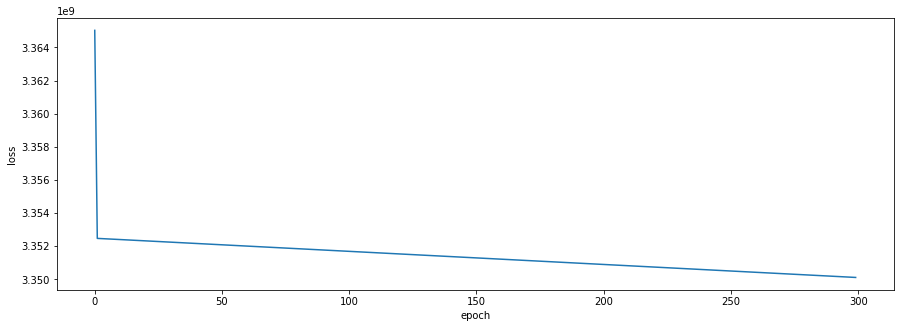

In [ ]:
lss = pd.Series(log.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

lss.plot(figsize=(15,5))
plt.show()

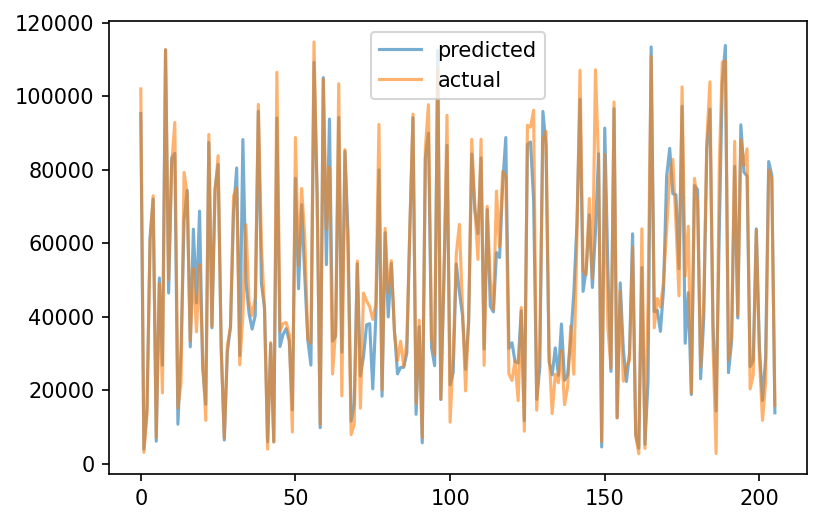

MAE :  5554.791990291262


In [ ]:
best_model = model_2
best_model.fit(X_train, y_train)
rental_count_prediction = best_model.predict(X_valid)

plt.figure(dpi=150)
plt.plot(rental_count_prediction, alpha=0.6, label='predicted')
plt.plot(y_valid.reset_index(drop=True), alpha=0.6, label='actual')
plt.legend()
plt.show()

mae = mean_absolute_error(rental_count_prediction, y_valid.reset_index(drop=True))
print('MAE : ', str(mae))

In [ ]:
print(X.shape)
print(y.shape)

(1026, 14)
(1026,)


In [ ]:
submission.head(1)

,date,rental
0,2021-01-01,0


In [ ]:
best_model.fit(X, y)
submission['rental'] = best_model.predict(test)

In [ ]:
submission.head(1)

,date,rental
0,2021-01-01,23991.07


In [ ]:
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submission-2022-06-13-ik.csv', index=False)

## submission result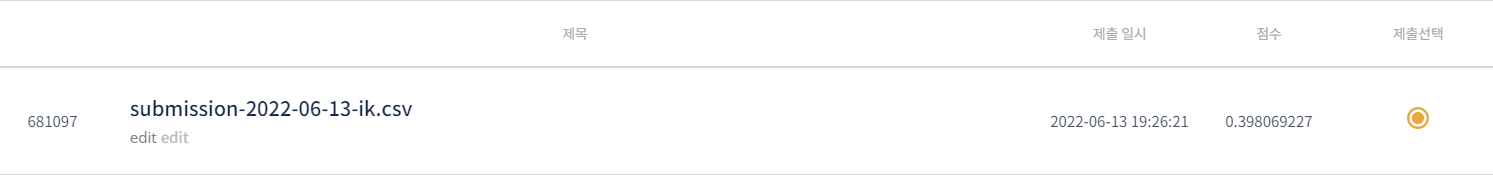